In [8]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from Shared.specific_CNB_sim import *

sim_name = f"Dopri5_1k"
sim_folder = f"sim_output/{sim_name}"
fig_folder = f"figures_local/{sim_name}"
Cl_folder = f"Shared/Cls"
nu_m_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
nu_m_picks = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
simdata = SimData(sim_folder)

exclude_nums = [
    20,  # broken halo
    25,  #? halo with only underdensities? look at skymap for this one...
]

# Fermi-Dirac distribution assumption
# note: total densities are computed for length 50 mass range
pix_dens_FD = jnp.load(f"{sim_folder}/pixel_densities.npy")
tot_dens_FD = jnp.load(f"{sim_folder}/total_densities.npy")
print(pix_dens_FD.shape)
print(tot_dens_FD.shape)

# Incl. primordial fluctuations, for all halos with 1 seed
# note: all sky densities are computed for 5 specific masses
pix_dens_PF_halos = jnp.load(f"{sim_folder}/pixel_densities_incl_PFs.npy")
tot_dens_PF_halos = jnp.load(f"{sim_folder}/total_densities_incl_PFs.npy")
print(pix_dens_PF_halos.shape)
print(tot_dens_PF_halos.shape)

# Incl. primordial fluctuations, for all halos with 1 seed
# note: all sky densities are computed for 5 specific masses
pix_dens_PF_seeds = jnp.load(f"{sim_folder}/pixel_densities_incl_PFs_seeds.npy")
tot_dens_PF_seeds = jnp.load(f"{sim_folder}/total_densities_incl_PFs_seeds.npy")
print(pix_dens_PF_seeds.shape)
print(tot_dens_PF_seeds.shape)

# Deltas_halos = jnp.load(f"{sim_folder}/Deltas_halos.npy")
# print(Deltas_halos.shape)

# Deltas_seeds = jnp.load(f"{sim_folder}/Deltas_seeds.npy")
# print(Deltas_seeds.shape)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(10, 50, 768)
(10, 50)
(10, 5, 768)
(10, 5)
(10, 5, 768)
(10, 5)


## Monopole perturbation

In [ ]:
colors = [
    "mediumblue", 
    "orangered"
]
labels = [
    "Fermi-Dirac", 
    "Primordial Fluctuations"
]

# SimPlot.overdensity_band(
#     dens_FD=tot_dens_FD,
#     dens_PF=tot_dens_PF_halos,
#     m_arr_FD=nu_m_range,
#     m_arr_PF=nu_m_picks,
#     colors=colors,
#     labels=labels,
#     plot_xlims=None,
#     plot_ylims=(1e-4,1e1),
#     plot_log=True,
#     fig_path=f"{fig_folder}/overdensity_band_{sim_name}.pdf",
#     args=Params())

SimPlot.overdensity_band(
    dens_FD=tot_dens_FD,
    dens_PF=tot_dens_PF_halos,
    m_arr_FD=nu_m_range,
    m_arr_PF=nu_m_picks,
    colors=colors,
    labels=labels,
    plot_xlims=(0, 0.2),
    plot_ylims=(0, 1),
    plot_log=False,
    fig_path=f"{fig_folder}/overdensity_band_{sim_name}_linear.pdf",
    args=Params())

In [ ]:
diff = jnp.abs(nu_m_range - nu_m_picks[:, None])
m_picks_indices = jnp.argmin(diff, axis=-1)
ic(nu_m_range[m_picks_indices])
tot_dens_FD_picks = tot_dens_FD[:, m_picks_indices]
ic(tot_dens_FD_picks.shape)
ic(tot_dens_PF_halos.shape)
colors = [
    "black", 
    "red"
]
labels = [
    "PF", 
    "MW + PF"
]

tot_dens_PF_only = (tot_dens_PF_halos-tot_dens_FD_picks)

SimPlot.overdensity_band(
    dens_FD=tot_dens_PF_only,
    dens_PF=tot_dens_PF_halos,
    m_arr_FD=nu_m_picks,
    m_arr_PF=nu_m_picks,
    colors=colors,
    labels=labels,
    plot_xlims=(0, 0.2),
    plot_ylims=(0, 1),
    plot_log=False,
    fig_path=f"{fig_folder}/overdensity_band_{sim_name}_linear_Elbers.pdf",
    args=Params())

## Dipole perturbation

In [ ]:
# How does the integrand in the average_velocity look like for option 2?

sim_dir = sim_folder
halo_num = 2
m_arr = nu_m_picks

vectors = SimData.load_vectors(sim_dir=sim_dir, halo_num=halo_num)
vels = vectors[..., 3:]

v_unit = Params.kpc/Params.s
v_z0 = vels[..., 0, :].reshape(halo_num, -1, 3)*v_unit

p_xyz, _ = Physics.velocities_to_momenta_individual(vels, m_arr, Params())

p_z0 = p_xyz[..., 0, :].reshape(halo_num, len(m_arr), -1, 3)
p_z4 = p_xyz[...,-1, :].reshape(halo_num, len(m_arr), -1, 3)

bulk_vels_FD = Physics.average_velocity(
    v_init=v_z0, 
    p_init=p_z0, 
    p_back=p_z4, 
    args=Params())

# note: option 1 (sorting) produces 

In [ ]:
colors = [
    "black", 
    "red"
]
labels = [
    "PF", 
    "MW + PF"
]

halo_limit = 2
SimPlot.bulk_velocity_band(
    sim_dir=sim_folder, 
    halo_num=halo_limit, 
    m_arr=nu_m_picks, 
    Deltas=jnp.load(f"{sim_folder}/Deltas_halos.npy")[:halo_limit,...], 
    colors=colors, 
    labels=labels, 
    plot_xlims=None, 
    plot_ylims=None, 
    # plot_ylims=(0,100), 
    fig_dir=fig_folder, 
    args=Params())

In [ ]:
# Load neutrino vectors for all halos
halo_num = 5
halo_vectors = SimData.load_vectors(sim_dir=sim_folder, halo_num=halo_num)
vels = halo_vectors[..., 3:]
ic(vels.shape)

v_z0 = vels[..., 0, :].reshape(halo_num, -1, 3)
v_z4 = vels[...,-1, :].reshape(halo_num, -1, 3)
ic(v_z0.shape)

p_xyz, _ = Physics.velocities_to_momenta_individual(vels, nu_m_picks, Params())
# print(p_xyz.shape, p_xyz.min()/Params.T_CNB)

p_z0 = p_xyz[..., 0, :].reshape(halo_num, len(nu_m_picks), -1, 3)
p_z4 = p_xyz[...,-1, :].reshape(halo_num, len(nu_m_picks), -1, 3)
ic(p_z0.shape)

v_unit = Params.kpc/Params.s

bulk_vels_FD = Physics.average_velocity(
    v_init=v_z0*v_unit, 
    p_init=p_z0, 
    p_back=p_z4, 

    args=Params())
bulk_vels_PF = Physics.average_velocity(
    v_init=v_z0*v_unit, 
    p_init=p_z0, 
    p_back=p_z4, 
    args=Params())

In [ ]:
fig = plt.figure(figsize=(6,6))
fig.tight_layout()
ax = fig.add_subplot(111)

bulk_mags = jnp.linalg.norm(bulk_vels_FD, axis=-1)/(Params.km/Params.s)

# Compute median and percentile ranges
bulk_FD_med = np.median(bulk_mags, axis=0)
bulk_FD_16 = np.percentile(bulk_mags, q=16, axis=0)
bulk_FD_84 = np.percentile(bulk_mags, q=84, axis=0)
bulk_FD_2p5 = np.percentile(bulk_mags, q=2.5, axis=0)
bulk_FD_97p5 = np.percentile(bulk_mags, q=97.5, axis=0)

colors = [
    "black", 
    "red"
]
labels = [
    "PF", 
    "MW + PF"
]

bulk_color = "black"

# Plot median of halo batch
ax.plot(
    nu_m_picks, bulk_FD_med, color=bulk_color, label="FD sim", alpha=0.7)

# Plot 84% C.L. band
ax.fill_between(
    nu_m_picks, bulk_FD_16, bulk_FD_84, 
    color=bulk_color, alpha=0.3, label=r"16 $-$ 84 % C.L.")

# Plot 97.5% C.L. band
ax.fill_between(
    nu_m_picks, bulk_FD_2p5, bulk_FD_97p5, 
    color=bulk_color, alpha=0.2, label=r"2.5 $-$ 97.5 % C.L.")


ax.set_title(f"Dipole perturbation")
ax.set_xlabel(r'$m_{\nu}$ [eV]', fontsize=16)
ax.set_ylabel(r'$v_{\nu}$ [km/s]', fontsize=16)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_ylim(0,500)
plt.grid(ls="dashed")

plt.savefig(f"{fig_folder}/dipole_perturbation.pdf", bbox_inches="tight")
plt.savefig(f"{fig_folder}/dipole_perturbation.png", bbox_inches="tight")
plt.show(); plt.close()

## CNB anisotropy x DM line-of-sight skymaps

In [ ]:
nu_vectors = jnp.load(f"{sim_folder}/vectors_halo1.npy")

nu_dens = Physics.number_densities_all_sky(
    v_arr=nu_vectors[..., 3:],
    m_arr=nu_m_range,
    pix_sr=simdata.pix_sr,
    args=Params())

# Choose which halo to plot
halo_i = 1

# Load associated origID of chosen halo
halo_indices = jnp.load(
    f"{sim_folder}/halo_batch_0.6-2.0x1e+12.0_Msun_indices.npy")
haloID = halo_indices[halo_i-1]

# Choose which neutrino mass to plot
m_val = 0.01
m_idx = jnp.abs(nu_m_range - m_val).argmin()

# Load corresponding number densities
CNB_dens_1mass = nu_dens[m_idx]
ic(CNB_dens_1mass.shape)
ic(CNB_dens_1mass.min(), CNB_dens_1mass.max())

CNB_skymap, DM_halo_skymap = SimPlot.skymaps_CNBxDM(
    nu_mass=m_val, 
    CNB_dens=CNB_dens_1mass, 
    DM_halo_pos=jnp.load(f"Data/halo_grids/DM_pos_origID{haloID}_snap_0036.npy"), 
    init_xyz=jnp.load(f"{sim_folder}/init_xyz_halo{halo_i}.npy"), 
    fig_path=f"{fig_folder}/skymaps_CNBxDM_{sim_name}.pdf",
    args=Params())

## Phase-space distributions today

In [ ]:
SimPlot.phase_space_2x2_FD_vs_PF(
    sim_dir=sim_folder, 
    m_picks=nu_m_picks, 
    halo_num=10, 
    fig_dir=fig_folder,
    args=Params())

#note TODO: 
# - add escape momentum vertical band

In [ ]:
SimPlot.momentum_distributions_2x2_FD_vs_PF(
    sim_dir=sim_folder, 
    m_picks=nu_m_picks, 
    halo_num=10, 
    fig_dir=fig_folder,
    args=Params())

## Temperature fluctuation skymaps from Cl

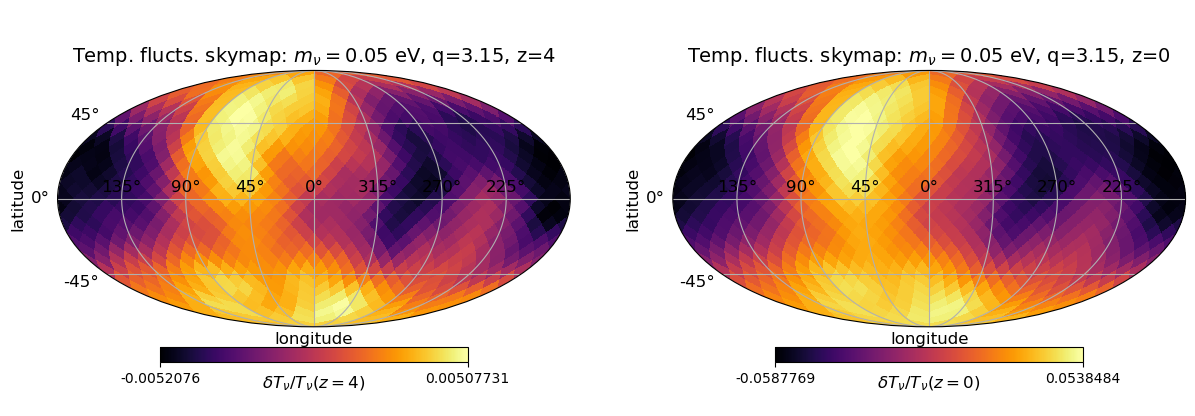

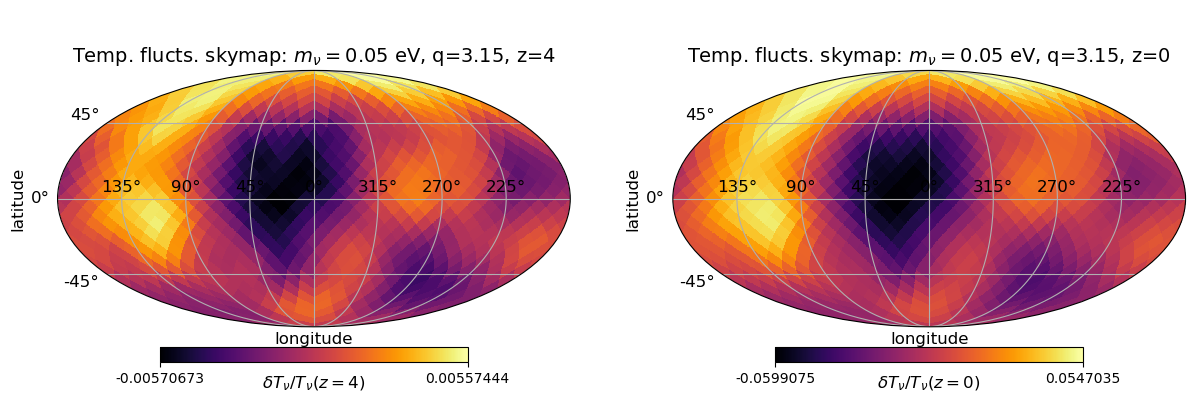

In [20]:
# SimPlot.temp_deltas_skymaps(
#     m_Cl=0.01, 
#     q_select=Primordial.q_select, 
#     Cl_qi=Primordial.Cl_qi, 
#     seed=Primordial.seed, 
#     Nside=simdata.Nside,
#     z4_val=simdata.z4_sim_val,
#     Cl_dir=Cl_folder, 
#     fig_dir=fig_folder,
#     args=Params)

# SimPlot.temp_deltas_skymaps(
#     m_Cl=0.05, 
#     q_select=Primordial.q_select, 
#     Cl_qi=Primordial.Cl_qi, 
#     seed=Primordial.seed, 
#     Nside=simdata.Nside,
#     z4_val=simdata.z4_sim_val,
#     Cl_dir=Cl_folder, 
#     fig_dir=fig_folder,
#     args=Params)

SimPlot.temp_deltas_skymaps(
    m_Cl=0.05, 
    q_select=Primordial.q_select, 
    Cl_qi=Primordial.Cl_qi, 
    seed=5, 
    Nside=simdata.Nside,
    z4_val=simdata.z4_sim_val,
    Cl_dir=Cl_folder, 
    fig_dir=fig_folder,
    args=Params)

SimPlot.temp_deltas_skymaps(
    m_Cl=0.05, 
    q_select=Primordial.q_select, 
    Cl_qi=Primordial.Cl_qi, 
    seed=0, 
    Nside=simdata.Nside,
    z4_val=simdata.z4_sim_val,
    Cl_dir=Cl_folder, 
    fig_dir=fig_folder,
    args=Params)

In [ ]:
print(f"Values from Tully & Zhang (2021) Fig. 5 left for 0.05 eV and q-averaged:")
conv_unit = Primordial.uK/Params.T_CNB*100
TZ_val_left = -176166*conv_unit
TZ_val_right = 157773*conv_unit
print(f"{TZ_val_left:.4f} to {TZ_val_right:.4f} % of T_CNB")

## Delta vs. redshift plot

In [ ]:
def Delta_vs_z_cut(m_arr, seed, Nside, Cl_dir, fig_dir, args):
    
    fig = plt.figure(figsize=(8,4))
    fig.tight_layout()
    ax = fig.add_subplot(111)

    for m_val in m_arr:
        
        # Load q-averaged Cl's for all z_cuts
        Cls_q_avg_pre = jnp.array([
            jnp.load(f"{Cl_dir}/Cls_q_averaged_z_cut={z_cut:.2f}_m={m_val}eV.npy")
            for z_cut in Primordial.z_cuts])
        # (z_cuts, 20)

        # Add the monopole term as 0 and choose a momentum to display
        Cls_q_avg = jnp.insert(Cls_q_avg_pre, 0, 0, axis=1)
        # (z_cuts, 21)

        # Generate temp. fluctuations (map) from Cls
        T_del_avg_l = []
        for Cls, z_cut in zip(Cls_q_avg, Primordial.z_cuts):

            np.random.seed(seed)
            Deltas = hp.sphtfunc.synfast(Cls, nside=Nside, lmax=None, pol=False)
            Deltas *= Primordial.uK/(Params.T_CNB * (1+z_cut))

            T_del_avg = (jnp.abs(jnp.min(Deltas)) + jnp.max(Deltas)) / 2
            T_del_avg_l.append(T_del_avg)

        
        ax.semilogx(
            1+Primordial.z_cuts, jnp.array(T_del_avg_l)*100, 
            label=fr"$m_\nu = {m_val}$ eV")
        ax.set_xlabel(f"1+z")
        ax.set_ylabel(fr"$\Delta T_\mathrm{{avg}} \, [\%]$")

    ax.axvline(4+1, color="red", ls="dotted")
    ax.text(4.9, 20, 'z=4', color='red', rotation=90, verticalalignment='center')

    ax.axvline(31+1, color="red", ls="dotted")
    ax.text(31+1e-1, 20, 'z=31', color='red', rotation=90, verticalalignment='center')

    ax.invert_xaxis()
    plt.grid(True, which="both", ls="dashed")
    plt.legend(loc="upper left", prop={"size":12})
    plt.savefig(f"{fig_dir}/Delta_vs_z_cuts.pdf")
    plt.savefig(f"{fig_dir}/Delta_vs_z_cuts.png")
    plt.show(); plt.close()

Delta_vs_z_cut(
    m_arr=nu_m_picks[0:4],
    seed=Primordial.seed,
    Nside=simdata.Nside,
    Cl_dir=Cl_folder,
    fig_dir=fig_folder,
    args=Params())

In [ ]:
def Delta_vs_z_cut_show(Cl_dir, m_arr, seed, Nside, args):

    Deltas_l = []
    for m_val in m_arr:
        
        # Load q-averaged Cl's for all z_cuts
        indices = jnp.array([0,9])
        z_cuts_select = Primordial.z_cuts[indices]
        Cls_q_avg_pre = jnp.array([
            jnp.load(f"{Cl_dir}/Cls_q_averaged_z_cut={z_cut:.2f}_m={m_val}eV.npy")
            for z_cut in z_cuts_select])
        # (z_cuts, 20)
        
        # Add the monopole term as 0 and choose a momentum to display
        Cls_q_avg = jnp.insert(Cls_q_avg_pre, 0, 0, axis=1)
        # (z_cuts, 21)
        
        # print(Cls_q_avg.shape)

        # Generate temp. fluctuations map
        for i in range(len(z_cuts_select)):

            np.random.seed(seed)
            Deltas = hp.sphtfunc.synfast(Cls_q_avg[i], nside=Nside, lmax=None, pol=False)

            z_cut_unit = Primordial.uK/(Params.T_CNB * (1+z_cuts_select[i]))
            Deltas *= z_cut_unit
            # print(Deltas.shape)
            Deltas_l.append(Deltas)

    Deltas_arr = jnp.array(Deltas_l)
    print(Deltas_arr.shape)

    Delta_cmap = "inferno"
    dict_z4 = dict(
        title=fr"Temp. flucts. skymap: $m_\nu={m_val}$ eV, q-averaged, z={Primordial.z_cuts[indices[-1]]}", 
        unit=r"$\delta T_\nu / T_\nu (z=4)$",
        cmap=Delta_cmap,
        sub=121)
    dict_z0 = dict(
        title=fr"Temp. flucts. skymap: $m_\nu={m_val}$ eV, q-averaged, z={Primordial.z_cuts[indices[0]]}", 
        unit=r"$\delta T_\nu / T_\nu (z=0)$",
        cmap=Delta_cmap,
        sub=122)

    SimPlot.healpix_side_by_side(
        Deltas_arr[-1], Deltas_arr[0], dict_z4, dict_z0, 
        f"{fig_folder}/Delta_skymaps_m={m_val}eV_q-averaged.pdf", args)

Delta_vs_z_cut_show(
    Cl_dir=Cl_folder,
    m_arr=nu_m_picks[0:1],
    seed=Primordial.seed,
    Nside=simdata.Nside,
    args=Params())

Delta_vs_z_cut_show(
    Cl_dir=Cl_folder,
    m_arr=nu_m_picks[1:2],
    seed=Primordial.seed,
    Nside=simdata.Nside,
    args=Params())

## Comparison of FD & PF skymaps

### For 1 halo with seed 5 (as in T&Z paper)

Sum of PF skymap 58.23473878458462
Sum of FD skymap 58.342440455834094


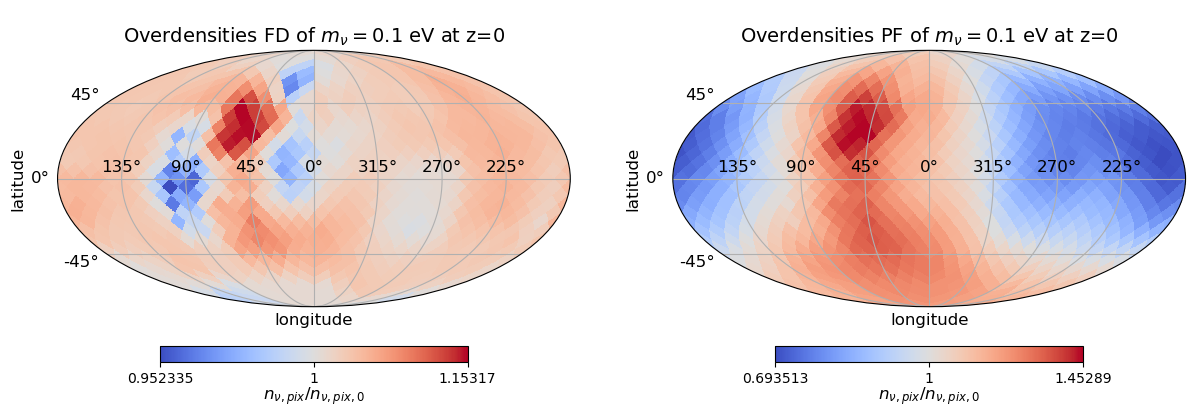

In [21]:
# Choose a halo and mass to display
halo_i = 1
m_pick = 0.1
mPF_i = jnp.abs(nu_m_picks - m_pick).argmin()
mFD_i = jnp.abs(nu_m_range - m_pick).argmin()

N0_pix = Params.N0 / simdata.Npix
skymap_norm = N0_pix / (Params.cm**-3)


### ------------------------------------------------------- ###
### Plot parameters for Primordial Fluctuations (FD) skymap ###
### ------------------------------------------------------- ###

PF_skymap = pix_dens_PF_halos[halo_i, mPF_i, :] / skymap_norm
print(f"Sum of PF skymap", PF_skymap.sum()*skymap_norm)

# Make center value to be 1 (no overdensity).
mid_PF = 1.
divnorm_PF = mcolors.TwoSlopeNorm(vcenter=mid_PF)

# Plot style healpy dictionary for right skymap
dict_PF = dict(
    title=fr"Overdensities PF of $m_\nu={m_pick}$ eV at z=0", 
    unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
    cmap="coolwarm",
    override_plot_properties={"cbar_pad": 0.1},
    cbar_ticks=[np.min(PF_skymap), mid_PF, np.max(PF_skymap)],
    norm=divnorm_PF,
    sub=122)


### ------------------------------------------- ###
### Plot parameters for Fermi-Dirac (FD) skymap ###
### ------------------------------------------- ###

FD_skymap = pix_dens_FD[halo_i, mFD_i, :] / skymap_norm
print(f"Sum of FD skymap", FD_skymap.sum()*skymap_norm)

# Make center value to be 1 (no overdensity).
mid_FD = 1.
divnorm_FD = mcolors.TwoSlopeNorm(vcenter=mid_FD)

# Plot style healpy dictionary for left skymap
dict_FD = dict(
    title=fr"Overdensities FD of $m_\nu={m_pick}$ eV at z=0", 
    unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
    cmap="coolwarm",
    override_plot_properties={"cbar_pad": 0.1},
    cbar_ticks=[np.min(FD_skymap), mid_FD, np.max(FD_skymap)],
    # cbar_ticks=[np.min(PF_skymap), mid_PF, np.max(PF_skymap)],
    norm=divnorm_FD,
    sub=121)


### ------------ ###
### Plot skymaps ###
### ------------ ###

SimPlot.healpix_side_by_side(
    map_left=FD_skymap,
    map_right=PF_skymap,
    dict_left=dict_FD,
    dict_right=dict_PF,
    fig_path=fig_folder,
    args=Params)

### For 1 halo and a different seed (for sanity check)

Sum of PF skymap 61.93296018695199
Sum of FD skymap 58.342440455834094


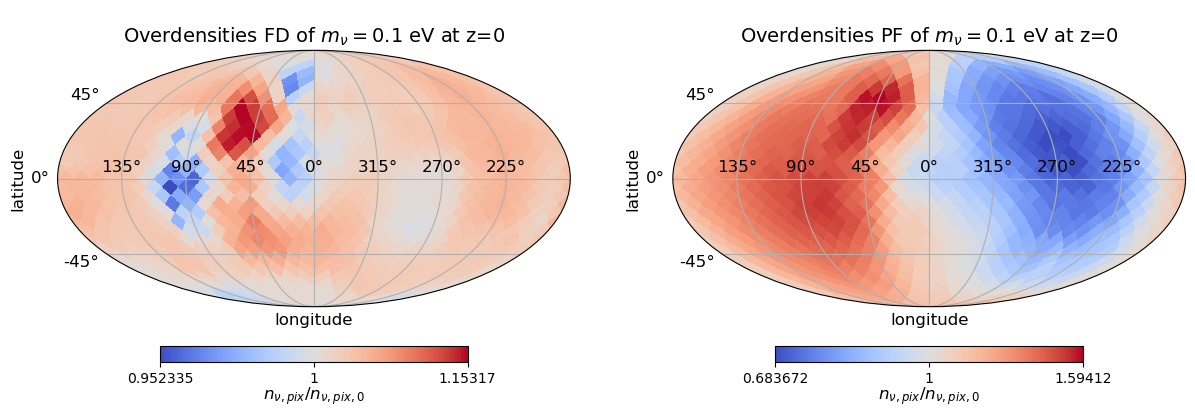

In [23]:
# Choose a halo and mass to display
seed_i = 0
halo_i = 1
m_pick = 0.1
mPF_i = jnp.abs(nu_m_picks - m_pick).argmin()
mFD_i = jnp.abs(nu_m_range - m_pick).argmin()

N0_pix = Params.N0 / simdata.Npix
skymap_norm = N0_pix / (Params.cm**-3)


### ------------------------------------------------------- ###
### Plot parameters for Primordial Fluctuations (FD) skymap ###
### ------------------------------------------------------- ###

PF_skymap = pix_dens_PF_seeds[seed_i, mPF_i, :] / skymap_norm
print(f"Sum of PF skymap", PF_skymap.sum()*skymap_norm)

# Make center value to be 1 (no overdensity).
mid_PF = 1.
divnorm_PF = mcolors.TwoSlopeNorm(vcenter=mid_PF)

# Plot style healpy dictionary for right skymap
dict_PF = dict(
    title=fr"Overdensities PF of $m_\nu={m_pick}$ eV at z=0", 
    unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
    cmap="coolwarm",
    override_plot_properties={"cbar_pad": 0.1},
    cbar_ticks=[np.min(PF_skymap), mid_PF, np.max(PF_skymap)],
    norm=divnorm_PF,
    sub=122)


### ------------------------------------------- ###
### Plot parameters for Fermi-Dirac (FD) skymap ###
### ------------------------------------------- ###

FD_skymap = pix_dens_FD[halo_i, mFD_i, :] / skymap_norm
print(f"Sum of FD skymap", FD_skymap.sum()*skymap_norm)

# Make center value to be 1 (no overdensity).
mid_FD = 1.
divnorm_FD = mcolors.TwoSlopeNorm(vcenter=mid_FD)

# Plot style healpy dictionary for left skymap
dict_FD = dict(
    title=fr"Overdensities FD of $m_\nu={m_pick}$ eV at z=0", 
    unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
    cmap="coolwarm",
    override_plot_properties={"cbar_pad": 0.1},
    cbar_ticks=[np.min(FD_skymap), mid_FD, np.max(FD_skymap)],
    # cbar_ticks=[np.min(PF_skymap), mid_PF, np.max(PF_skymap)],
    norm=divnorm_FD,
    sub=121)


### ------------ ###
### Plot skymaps ###
### ------------ ###

SimPlot.healpix_side_by_side(
    map_left=FD_skymap,
    map_right=PF_skymap,
    dict_left=dict_FD,
    dict_right=dict_PF,
    fig_path=fig_folder,
    args=Params)

## Comparison of FD & PF power spectra

### 10 Halos - 1 PF

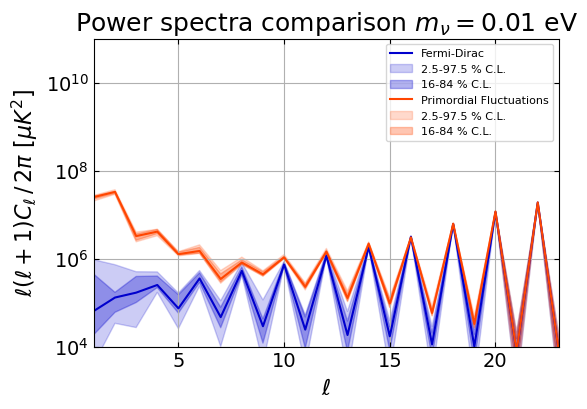

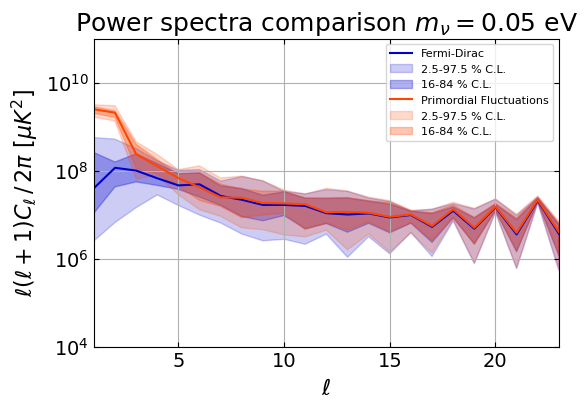

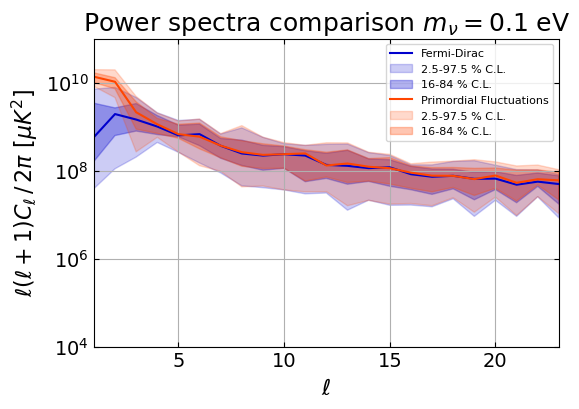

In [9]:
N0_pix = Params.N0 / simdata.Npix
skymap_norm = N0_pix / (Params.cm**-3)
for m_pick in (0.01, 0.05, 0.1):
    SimPlot.power_spectra_FDxPF_10Halos1PF(
        m_pick=m_pick, 
        pix_dens_FD=pix_dens_FD / skymap_norm, 
        pix_dens_PF=pix_dens_PF_halos / skymap_norm, 
        sim_dir=sim_folder, 
        fig_dir=fig_folder,
        args=Params)

### 1 Halo - 10 PFs

In [5]:
pix_dens_PF_seeds.shape

(10, 5, 768)

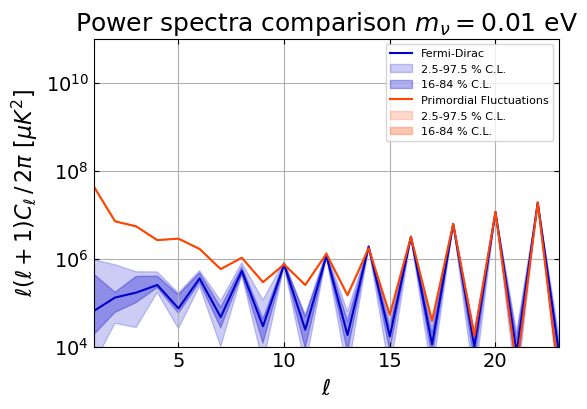

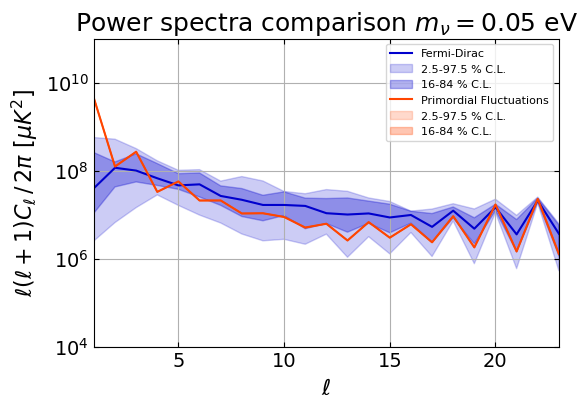

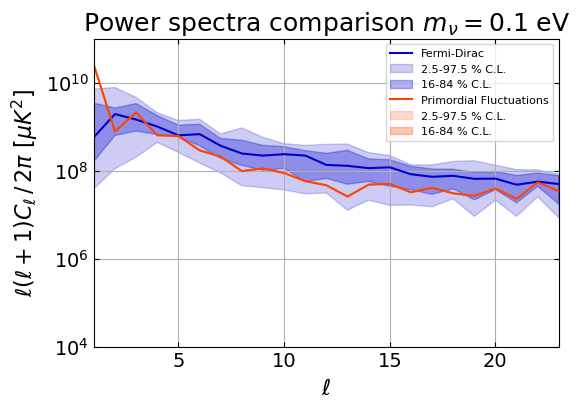

In [4]:
N0_pix = Params.N0 / simdata.Npix
skymap_norm = N0_pix / (Params.cm**-3)
for m_pick in (0.01, 0.05, 0.1):
    SimPlot.power_spectra_FDxPF_10Halos1PF(
        m_pick=m_pick, 
        pix_dens_FD=pix_dens_FD / skymap_norm, 
        pix_dens_PF=pix_dens_PF_seeds / skymap_norm, 
        sim_dir=sim_folder, 
        fig_dir=fig_folder,
        args=Params)

## Percentage in certain velocity range

In [ ]:
def compute_percentages(v_arr, v_min, v_max, m_arr, args):

    vels_z0 = v_arr[:, 0, :]

    # Condition for having neutrinos with velocities in range, today
    mags_z0 = jnp.linalg.norm(vels_z0, axis=-1)*args.kpc/args.s
    cond = (v_min <= mags_z0) & (mags_z0 <= v_max)

    vels_range = v_arr[cond, ...]

    # Compute number densities for neutrinos in velocity range
    dens_range = Physics.number_densities_mass_range(
        vels_range, m_arr, 4*args.Pi, args)

    dens_total = Physics.number_densities_mass_range(
        v_arr, m_arr, 4*args.Pi, args)

    # Percentages 
    perc_range = dens_range/dens_total*100
    percs = [f"{perc:.3f}" for perc in perc_range]
    print(percs)


# Pick a halo
halo_i = 1

# Load velocities
vels = jnp.array(
    [jnp.load(f"{sim_folder}/vectors_halo{i+1}.npy") for i in range(10)]
)[0, ..., 3:].reshape((-1, 2, 3))
# ic(vels.shape)

vels_z0 = vels[:, 0, :]
# ic(vels_z0.shape)

vels_only_z0s = jnp.repeat(jnp.expand_dims(vels_z0, axis=1), repeats=2, axis=1)
# ic(vels_only_z0s.shape)

# Pick velocity range (as in https://arxiv.org/abs/1305.2454), units of c


v_min = 0.01
v_max = 0.14
print(f"Velocities between {v_min}c and {v_max}c :")
print(f"  0.01      0.05       0.1      0.2       0.3   eV")
compute_percentages(v_arr=vels, v_min=v_min, v_max=v_max, m_arr=nu_m_picks, args=Params())
compute_percentages(v_arr=vels_only_z0s, v_min=v_min, v_max=v_max, m_arr=nu_m_picks, args=Params())

print("\n")

v_min = 0.001
v_max = 0.01
print(f"Velocities between {v_min}c and {v_max}c :")
print(f"  0.01      0.05       0.1      0.2       0.3   eV")
compute_percentages(v_arr=vels, v_min=v_min, v_max=v_max, m_arr=nu_m_picks, args=Params())
compute_percentages(v_arr=vels_only_z0s, v_min=v_min, v_max=v_max, m_arr=nu_m_picks, args=Params())

## Momentum distributions

In [ ]:
def momentum_distribution(y_arr, nbins, args):
    """
    Plot a momentum histogram with logarithmically spaced bins.
    """

    # Generating logarithmically spaced bins
    log_bins = np.logspace(
            np.log10(np.min(y_arr)), np.log10(np.max(y_arr)), nbins)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Plot simulation distances
    ax.hist(
        y_arr, bins=log_bins, 
        color="blue", label="CNB simulation", alpha=0.8)
    
    ax.set_xscale("log")
    ax.set_title("Momentum distribution at z=4 (Log Bins)")
    ax.set_xlabel(r"$p_\mathrm{back}/T_\mathrm{CNB,0}$")
    ax.set_ylabel("Nr. of neutrinos")
    ax.legend(loc="upper left")

    plt.show(); plt.close()


# Load neutrino vectors for specified halo
halo = 1
nu_vectors = jnp.load(f'{sim_folder}/vectors_halo{halo}.npy')

# Convert to momenta
v_arr = nu_vectors[...,3:]
p_arr, y_arr = Physics.velocities_to_momenta_all_sky(
    v_arr, nu_m_picks, Params())

for m_idx in range(len(nu_m_picks)):
# for m_idx in range(1):

    # Set up plot parameters
    z0_y_arr = y_arr[m_idx, ..., 0].reshape(-1,)
    z4_y_arr = y_arr[m_idx, ...,-1].reshape(-1,)#/(1+4)
    nbins = 50

    # Generating logarithmically spaced bins
    log_bins = np.logspace(
            np.log10(np.min(z0_y_arr)), np.log10(np.max(z0_y_arr)), nbins)

    # fig = plt.figure()
    # ax = fig.add_subplot(111)

    print("**************************************")
    print("Momentum endpoints for Cl(q) generation:")
    print(f"z0: Min = {jnp.min(z0_y_arr)} T_CNB ; Max = {jnp.max(z0_y_arr)} T_CNB")
    print(f"z4: Min = {jnp.min(z4_y_arr)} T_CNB ; Max = {jnp.max(z4_y_arr)} T_CNB")
    print("**************************************\n")

    # print('#? are the highest momenta affected by gravity? If yes how much?')
    # last_x = 5
    # print(jnp.count_nonzero(jnp.abs(z0_y_arr[-last_x:] - z4_y_arr[-last_x:])))
    # diff_high = jnp.abs(z0_y_arr[-last_x:] - z4_y_arr[-last_x:])
    # print(diff_high/z0_y_arr[-last_x:])
    # print('very little difference!\n')

    # print('#? are the lowest momenta affected by gravity? If yes how much?')
    # first_x = 5
    # print(jnp.count_nonzero(jnp.abs(z0_y_arr[:first_x] - z4_y_arr[:first_x])))
    # diff_low = jnp.abs(z0_y_arr[:first_x] - z4_y_arr[:first_x])
    # print(diff_low/z0_y_arr[:first_x])
    # print('more than 1 order of magnitude bigger difference than for higher momenta!\n')
    
    # note: all masses are affected the same due to the nature of gravity, i.e. the fractional differences for the z0/z4 momenta are the same for all masses.
    
    """
    # Sample Fermi-Dirac momenta
    samples = 1_000
    max_p = jnp.max(z0_y_arr*Params.T_CNB)
    print(f"Maximum momentum for Fermi-Dirac sampling = {max_p/Params.T_CNB:.4f} [T_CNB]\n")
    FD_momenta_z0 = Physics.sample_Fermi_Dirac_momentum(
        N=samples, T=Params.T_CNB, p_norm=max_p)
    # p_norm is the maximum momentum sampled, and is used for normalization

    FD_momenta_z4 = FD_momenta_z0*(1+4)

    # Randomly draw from simulation momenta, to match number of Fermi-Dirac samples
    z0_y_sync = jax.random.choice(Params.key, z0_y_arr, shape=(samples,), replace=False)
    z4_y_sync = jax.random.choice(Params.key, z4_y_arr, shape=(samples,), replace=False)

    # Plot momenta
    ax.hist(z0_y_sync, bins=log_bins, color="blue", label="Sim z=0", alpha=0.7)
    ax.hist(z4_y_sync, bins=log_bins, color="red", label="Sim z=4", alpha=0.7)
    ax.hist(FD_momenta_z4/Params.T_CNB, bins=log_bins, color="orange", label="FD z=4", alpha=0.7)

    ax.set_xscale("log")
    ax.set_title(rf"Momentum distribution (Log Bins) for $m_{{\nu}}={nu_m_picks[m_idx]}$")
    ax.set_xlabel(r"$p_\mathrm{back}/T_\mathrm{CNB,0}$")
    ax.set_ylabel("Nr. of neutrinos")
    ax.legend(loc="upper left")

    plt.show(); plt.close()
    """